## Home Credit competition

- 他のチームの結果を参考に, LightGBMの使い方, pythonコードの作成方法についてまとめる
- コメント文など適宜追加する

## References

- [Kaggle:How to LightGBM with lightgbm.cv](https://www.kaggle.com/shep312/lightgbm-harder-better-slower/code)
- [Python API](https://lightgbm.readthedocs.io/en/latest/Python-API.html)
- [roc auc score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html0)
- [1st place solution](https://www.kaggle.com/c/home-credit-default-risk/discussion/64821)
- [2nd place solution](https://www.kaggle.com/c/home-credit-default-risk/discussion/64722)

## winner session summary



In [1]:
# import module
import gc, os, sys, warnings,time
import requests
from tqdm import tqdm
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from contextlib import contextmanager
from multiprocessing import cpu_count, Pool
from collections import defaultdict
from glob import glob
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold

# set path
sys.path.append("/Users/takuto/Desktop/Home_Credit_Kaggle/py/") # for macbook
sys.path.append("/Users/takutokotsubo/Desktop/Home_Credit_Kaggle/py/") # for imac

0


## function

- @contextmanager: with文を用いて簡単に実行時間を計測できる関数を作成できる
- one-hot: デジタル回路において, 1つだけ"1"の値をとり, 他の全ての値が"0"であるようなビット列, ダミー変数化では0,1の値を用いて区別するので少し意味合いが違うことに注意
- gc.collect(): del -> gc.collect()でメモリを開放でできる

In [2]:
# Execution time measuring
@contextmanager
def timer(title):
    t0 = time.time()
    yield print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == "object"]
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df,new_columns

# preprocess all data
def read_all_data(num_rows = None, nan_as_category = False):
    df = pd.read_csv("../csv_imp/all_data_train.csv", nrows = num_rows)
    test = pd.read_csv("../csv_imp/all_data_test.csv", nrows = num_rows)
    df = df.append(test).reset_index()
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    del test
    gc.collect()
    return df

# LightGBM with kfold or Stratified kfold
def kfold_lightgbm(df, num_folds, stratified = False, debug = False):
    train_df = df[df["TARGET"].notnull()]
    test_df = df[df["TARGET"].isnull()]
    print("Starting Light GBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    
    # cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits = num_folds, shuffle=True, random_state= 831)
    else:
        folds = KFold(n_splits = num_folds, shuffle=True, random_state=831)
        
    # Create arrays and dataframes
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ["TARGET","SK_ID_CURR","SK_ID_BUREAU","SK_ID_PREV","index"]]
    
    # kfold
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats],train_df["TARGET"])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df["TARGET"].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df["TARGET"].iloc[valid_idx]
        
        # LightGBM parameters 
        clf = LGBMClassifier(
            learning_rate = 0.01,
            max_depth = 6,
            num_leaves = 63,
            max_bin = 255,
            min_child_weight = 10,
            min_data_in_leaf = 150,
            reg_lambda = 0.5,  # L2 regularization term on weights.
            reg_alpha = 0.5,  # L1 regularization term on weights.
            colsample_bytree = 0.9,
            subsample = 0.9,
            nthread = cpu_count(), # max thread
            silent = -1, 
            verbose = -1,
        )
        clf.fit(train_x,train_y,eval_set=[(train_x,train_y), (valid_x,valid_y)],
                eval_metric = 'auc',verbose=100,early_stopping_rounds= 200)
        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()
        
        print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
        # Write submission file and plot feature importance
        if not debug:
            test_df['TARGET'] = sub_preds
            test_df = test_df.astype({"SK_ID_CURR":int}) # change dtypes
            test_df[['SK_ID_CURR', 'TARGET']].to_csv("../submit/" + submission_file_name, index= False)
        display_importances(feature_importance_df)
        return feature_importance_df

# LightGBM with cv by onodera
def cv_lightgbm(df, num_folds, NFOLD, LOOP, debug = False):
    # parameters
    param = {
         'objective': 'binary',
         'metric': 'auc',
         'learning_rate': 0.01,
         'max_depth': 6,
         'num_leaves': 63,
         'max_bin': 255,
         
         'min_child_weight': 10,
         'min_data_in_leaf': 150,
         'reg_lambda': 0.5,  # L2 regularization term on weights.
         'reg_alpha': 0.5,  # L1 regularization term on weights.
         
         'colsample_bytree': 0.9,
         'subsample': 0.9,
         'nthread': cpu_count(),
         'bagging_freq': 1,
         'verbose':-1,
         }
    train_df = df[df["TARGET"].notnull()]
    test_df = df[df["TARGET"].isnull()]
    print("Starting Light GBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df; gc.collect()
    # non list
    feats = [f for f in train_df.columns if f not in ["TARGET","SK_ID_CURR","SK_ID_BUREAU","SK_ID_PREV","index"]]
    train_x, train_y, test_X = train_df[feats], train_df["TARGET"], test_df[feats]      
    dtrain = lgb.Dataset(train_x,train_y)
    gc.collect()
    # result box
    model_all = []
    y_pred = pd.Series(0, index=train_y.index)
    
    # training with cv
    for i in range(LOOP):
        gc.collect()
        ret, models = lgb.cv(param, dtrain, 9999, nfold=NFOLD,
                             early_stopping_rounds=100, verbose_eval=50, seed=i)
        model_all += models
        
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    # plt.savefig('lgbm_importances01.png')

# send message to line
def send_line(message):
    
    line_notify_token = '5p5sPTY7PrQaB8Wnwp6aadfiqC8m2zh6Q8llrfNisGT'
    line_notify_api = 'https://notify-api.line.me/api/notify'
    
    payload = {'message': message}
    headers = {'Authorization': 'Bearer ' + line_notify_token}
    requests.post(line_notify_api, data=payload, headers=headers)

# main 
def main(debug = False):
    num_rows = 100000 if debug else None # for debug
    df = read_all_data(num_rows)
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 5, stratified= False, debug= debug)

## Main

Full model run - done in 0s
Run LightGBM with kfold - done in 0s
Starting Light GBM. Train shape: (307511, 1309), test shape: (48744, 1309)
Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.773855	valid_1's auc: 0.744432
Did not meet early stopping. Best iteration is:
[100]	training's auc: 0.773855	valid_1's auc: 0.744432
Fold  1 AUC : 0.744432
Full AUC score 0.512573


/Users/takutokotsubo/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


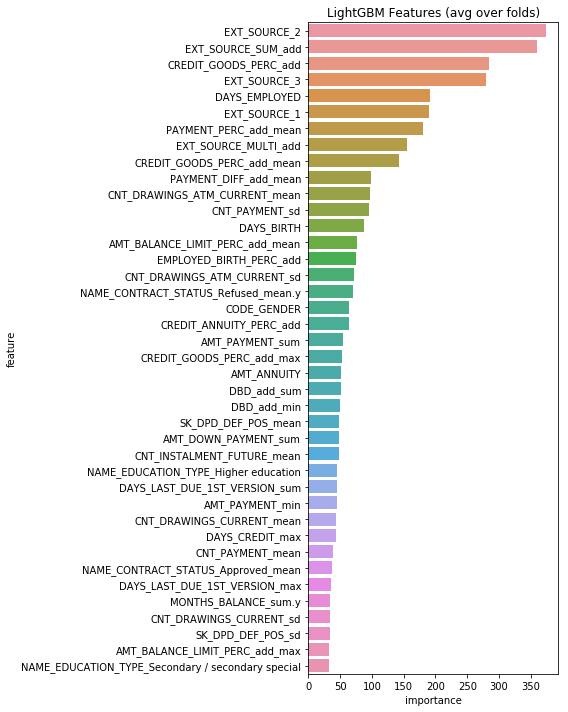

In [66]:
if __name__ == "__main__":
    submission_file_name = "submission_lightgbm_test.csv"
    with timer("Full model run"):
        main(debug=False)

## Light GBM cross validation

In [3]:
LOOP = 1
NFOLD = 4 # good set: 7
num_rows = 100000 # good set: FALSE

In [4]:
# parameters
param = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 6,
    'num_leaves': 63,
    'max_bin': 255,
    
    'min_child_weight': 10,
    'min_data_in_leaf': 150,
    'reg_lambda': 0.5,  # L2 regularization term on weights.
    'reg_alpha': 0.5,  # L1 regularization term on weights.
         
    'colsample_bytree': 0.9,
    'subsample': 0.9,
    'nthread': cpu_count(),
    'bagging_freq': 1,
    'verbose':-1,
}
df = read_all_data(num_rows)
train_df = df[df["TARGET"].notnull()]
test_df = df[df["TARGET"].isnull()]

del df; gc.collect()
# non list
feats = [f for f in train_df.columns if f not in ["TARGET","SK_ID_CURR","SK_ID_BUREAU","SK_ID_PREV","index"]]
X_train, y_train, X_test = train_df[feats], train_df["TARGET"], test_df[feats]      
dtrain = lgb.Dataset(X_train,y_train,free_raw_data=False)
gc.collect()
# result box
model_all = []
y_pred = pd.Series(0, index=y_train.index)
    
# training with cv
for i in range(LOOP):
    gc.collect()
    # cross validation
    print("Starting Light GBM {}-fold cross varidation. Train shape: {}, test shape: {}"
          .format(NFOLD, train_df.shape, test_df.shape))
    models_cv = lgb.cv(param, dtrain, 9999, nfold=NFOLD,
                       early_stopping_rounds=100, verbose_eval=50, seed=i)
    print("best n_estimator", len(models_cv["auc-mean"])) # best iteration
    print("best cv score", models_cv["auc-mean"][-1]) # best cv score
    # execute model
    print("Starting Light GBM Training. Train shape: {}, test shape: {}, best iter: {}"
          .format(train_df.shape, test_df.shape, len(models_cv["auc-mean"])))
    models_train = lgb.train(param,dtrain,num_boost_round=len(models_cv["auc-mean"]))
    # predict target (model.best_iteration??)
    print("Starting Light GBM Predict. Train shape: {}, test shape: {}, num iter: {}"
          .format(train_df.shape, test_df.shape, model.best_iteration))
    pred_train = models_train.predict(train_x)
    
    # roc_auc score
    auc_mean = roc_auc_score(train_y,pred_train)
    print(f"CV auc-mean(loop {i}): {auc_mean} {models['auc-mean'][-1]}")
    
    #model_all += models

Starting Light GBM. Train shape: (100000, 1249), test shape: (48744, 1249)
[50]	cv_agg's auc: 0.739865 + 0.00530914
[100]	cv_agg's auc: 0.748384 + 0.00492817
[150]	cv_agg's auc: 0.755235 + 0.0051312
[200]	cv_agg's auc: 0.760772 + 0.00515155
[250]	cv_agg's auc: 0.765231 + 0.00518327
[300]	cv_agg's auc: 0.768735 + 0.00514554
[350]	cv_agg's auc: 0.771354 + 0.00501918
[400]	cv_agg's auc: 0.773395 + 0.00499893
[450]	cv_agg's auc: 0.774978 + 0.00491874
[500]	cv_agg's auc: 0.776176 + 0.00480619
[550]	cv_agg's auc: 0.777201 + 0.00473125
[600]	cv_agg's auc: 0.778139 + 0.00482851
[650]	cv_agg's auc: 0.778704 + 0.00479878
[700]	cv_agg's auc: 0.779226 + 0.0047764
[750]	cv_agg's auc: 0.779701 + 0.00472962
[800]	cv_agg's auc: 0.780142 + 0.00475922
[850]	cv_agg's auc: 0.780472 + 0.00484431
[900]	cv_agg's auc: 0.78072 + 0.00482255
[950]	cv_agg's auc: 0.781038 + 0.00483704
[1000]	cv_agg's auc: 0.781262 + 0.0048973
[1050]	cv_agg's auc: 0.781368 + 0.00495173
[1100]	cv_agg's auc: 0.78157 + 0.00491519
[115

NameError: name 'models' is not defined

In [5]:
print("best n_estimator", len(models_cv["auc-mean"])) # best iteration
print("best cv score", models_cv["auc-mean"][-1]) # best cv score

best n_estimator 1672
best cv score 0.7823590127147184


In [11]:
print("Starting Light GBM Training. Train shape: {}, test shape: {}, best iter: {}"
      .format(train_df.shape, test_df.shape, len(models_cv["auc-mean"])))
models_train = lgb.train(param,dtrain,num_boost_round=len(models_cv["auc-mean"]),verbose_eval=50)


Starting Light GBM Training. Train shape: (100000, 1249), test shape: (48744, 1249), best iter: 1672


In [20]:
models_train = lgb.train(param,dtrain,num_boost_round=len(models_cv["auc-mean"]))

In [27]:
models_train.best_iteration

0